In [1]:
# EE403 Capstone Project By Brandon Beader, Ryan Lukachek, and Chris Palmer

# Version 005 changelog:

# added math library import
# added additional comments to help explain processes
# added new code to choose which event loading method to use
# added print statements to display values (mostly for debugging)
# added working NMS implementation
# removed redundant library imports
# renamed Hough Script variables for better clarity


In [2]:
# Initialize necessary tools
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import math

from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader

In [3]:
# Choose Raw Event File - Must be saved in same folder as this file
input_path_raw = "marker.raw"

# open the file
record_raw = RawReader(input_path_raw)
print(record_raw)  # show some metadata

# Get Events - type either 'time' or 'num' below to decide between event collection methods
method = 'time'

# Number Based:
if method == 'num': 
    event_num = 10000 # number of events to be loaded
    events = record_raw.load_n_events(event_num)  # load next n events
    print('num-based method chosen; ',event_num, 'frames loaded')

# Time/Frame Based:
if method == 'time': 
    events = record_raw.load_delta_t(50000)  # load the next 50ms of data (value given in microseconds)
    event_num = events.size
    print('time-based method chosen; ',event_num, 'frames loaded')

# NOTE: See core tutorial labeled "RAW File Loading" to better understand the format that events are given in

RawReader(marker.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 100000000
time-based method chosen;  10143 frames loaded


In [4]:
# Extract Event Data Coordinates and frame size
y_values = events['y']
x_values = events['x']

height, width = record_raw.get_size()

# Display some data
print('Height is ', height, '\n','Width is ', width)

Height is  480 
 Width is  640


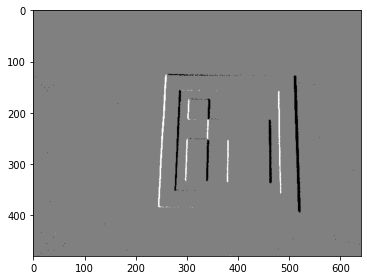

In [5]:
# Visualize Events (Not necessary for final functionality)
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

im = viz_events(events, height, width)

#np.savetxt('myfile.csv', im[:,:,1], delimiter=',')
cv2.imwrite('test_jpg.jpg',im) #Save event image array as jpg ---NECESSARY FOR TRADITIONAL HOUGH TRANSFORM---

# Display the current events
plt.imshow(im)
plt.tight_layout()

Accumulator is a  180  by  280  Array


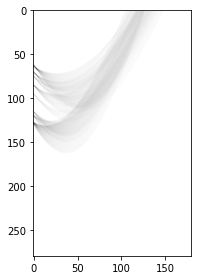

In [6]:
# Hough Transform 
#   Decrease theta_res for increased degree accuracy
#   Increase rho_res for increased rho accuracy
#   Note accuracy increases result in larger computational load

theta_res = 1                                          # Spacing between theta scale values (in degrees)
theta_scale_values = np.arange(0,180,theta_res)        # Theta scale values (0-180 degrees)
rho_res = 0.25                                         # Rho resolution for accumulator array (1 gives 1 index/pixel, per integer rho value)
rho_max = int(np.floor((height + width)*rho_res))      # Largest possible rho value (derived from rho equation)
H = np.zeros((rho_max,180))                            # Accumulator array initialized to zeros array

# Display some info about accumulator size
print('Accumulator is a ', len(H[0]), ' by ', len(H), ' Array')

# Loop through each event
for event in range(event_num):
    # For each theta value (0-180) in this event, calculate rho
    for theta in theta_scale_values:
        # rho = x*cos(theta) + y*sin(theta)      (rounded down to prevent OutOfBounds errors)
        rho = int(np.floor((x_values[event]*np.cos(np.deg2rad(theta)) + y_values[event] * np.sin(np.deg2rad(theta)))*rho_res))
        # If this rho is positive, cast a 'vote' in the accumulator at that position. Then move on to next theta value
        if rho > 0:
            H[rho][theta] = H[rho][theta]+1

# Display Hough Space output
plt.imshow(H, cmap = 'binary')
plt.tight_layout()

Accumulator is temporarily padded to a  184  by  284  Array
Accumulator is once again a  180  by  280  Array


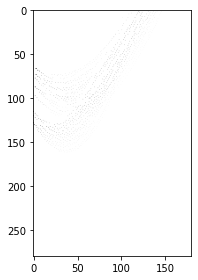

In [7]:
# Non-Maximal Suppression - WORKING
#   The purpose of this is to clear out near matches from the highest points so that multiple lines will not repeat over one another
#   The current code will remove the 12 nearest neighbors in a diamond shape from the accumulator starting at (0,0)
H2 = np.pad(H,(2,2))
rows,cols = len(H2), H2[0].size
print('Accumulator is temporarily padded to a ', cols, ' by ', rows, ' Array')
# For each H coordinate (shifted to account for padding on H2)
for r in range(rows-4):
    for c in range(cols-4):
        # if this value has less votes than its 12 neighbors...zero it
        if (H2[2+r,2+c] < H2[1+r,1+c]) or (H2[2+r,2+c] < H2[3+r,1+c]) or \
           (H2[2+r,2+c] < H2[1+r,2+c]) or (H2[2+r,2+c] < H2[3+r,2+c]) or \
           (H2[2+r,2+c] < H2[1+r,3+c]) or (H2[2+r,2+c] < H2[3+r,3+c]) or \
           (H2[2+r,2+c] < H2[2+r,1+c]) or (H2[2+r,2+c] < H2[2+r,3+c]) or \
           \
           (H2[2+r,2+c] < H2[0+r,2+c]) or (H2[2+r,2+c] < H2[2+r,0+c]) or \
           (H2[2+r,2+c] < H2[4+r,2+c]) or (H2[2+r,2+c] < H2[2+r,4+c]):
            H2[2+r,2+c] = 0
# Remove temporary padding
H3 = H2[2:(rows-2), 2:(cols-2)]

# Display Hough Space output
print('Accumulator is once again a ', len(H3[0]), ' by ', len(H3), ' Array')
plt.imshow(H3, cmap = 'binary')
plt.tight_layout()


In [ ]:
### Next Steps:

# add num_lines user defined variable
# Select top n points from the NMS Accumulator (H3)
# Plot those lines as seen below


### Ambitions Next steps:

# figure out how to get the lines to stay on target (not extend forever)

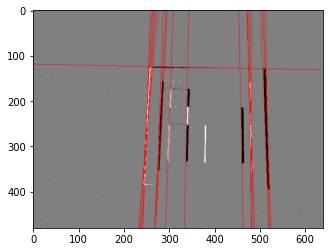

In [8]:
# Test for displaying lines using built-in functions
img = cv2.imread('test_jpg.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_edges = cv2.Canny(img_gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(img_edges,1,np.pi/180,80)

for line in lines:
    for rho,theta in line:
        a=np.cos(theta)
        b=np.sin(theta)
        x0=a*rho
        y0=b*rho
        x1=int(x0+1000*(-b))
        y1=int(y0+1000*(a))
        x2=int(x0-1000*(-b))
        y2=int(y0-1000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)

plt.imshow(img)


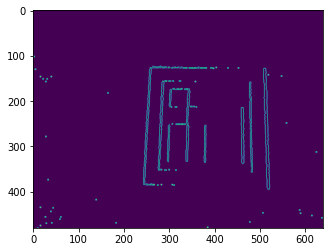

In [9]:
plt.imshow(img_edges)

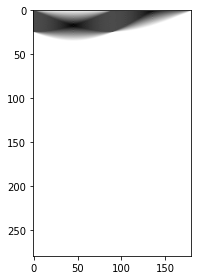

In [10]:
# Traditional Image Hough Transform ------- Confused about this
# image size limited to 100x100 right now for computation purposes

G = np.zeros((rho_max,180))         # Accumulator array initialized to zeros array

for x in range(100): 
    for y in range(100): 
        for thta in theta_scale_values:
            rho = int(np.floor((x*np.cos(np.deg2rad(thta)) + y* np.sin(np.deg2rad(thta)))*rho_res))
            if rho > 0:
                G[rho][thta] = G[rho][thta]+1

plt.imshow(G, cmap = 'binary')
plt.tight_layout()